# Exploration9 인물사진을 만들어 보자

In [54]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image

In [55]:
class DeepLabModel(object): #Pixellib의 기능중 하나인 DeepLabModel
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- pixllib이 코랩에서 자꾸 오류가 나서 DeepLabModel을 가져왔다.
- Image Segmentation 기능은 똑같아서 그냥 써도 될 것 같다.

In [56]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/exploration/Ex9/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)

temp directory: /content/drive/MyDrive/exploration/Ex9/models


- DeepLabModel을 생성하고, 훈련이 완료된 모델을 텐서플로우에서 가져온다.

In [57]:
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 
               'bird', 'boat', 'bottle', 'bus', 'car', 
               'cat', 'chair', 'cow', 'diningtable', 'dog', 
               'horse', 'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tv']

- 각 훈련 된 라벨의 '키'

In [90]:
img_dir_path = '/content/drive/MyDrive/exploration/Ex9'
save_dir_path = '/content/drive/MyDrive/exploration/Ex9/new_img'

# 블러 처리

In [59]:
def blur_background(file, label):
    # 이미지 불러오기
    img_path = os.path.join(img_dir_path, file)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 pre-trained 모델에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())

    # 배경과 피사체 분리하기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) # 예측 중 특정 라벨만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 배경 흐리게 하기
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    plt.imshow(img_bg)
    plt.show()

    img_bg_blur = cv2.blur(img_bg, (13,13))
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    # 흐린 배경과 원본 이미지 합성 후 저장
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    save_path = os.path.join(save_dir_path, file)
    cv2.imwrite(save_path, img_concat)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

- 사진 블러처리까지의 진행상황을 나타낸 함수

(1440, 1080, 3) (513, 384, 3) 15


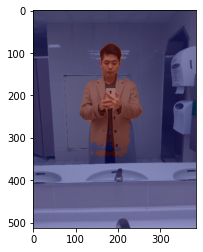

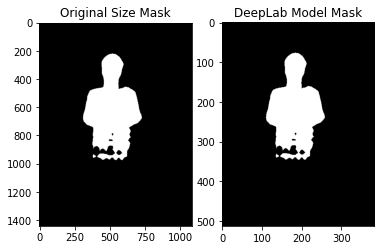

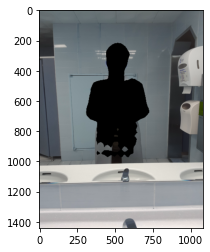

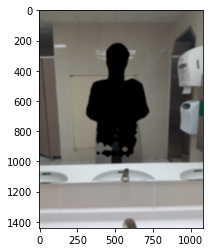

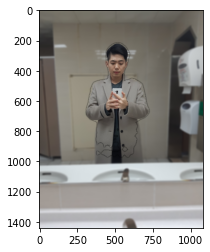

In [60]:
blur_background('one1.jpg', 'person')

(540, 540, 3) (513, 513, 3) 15


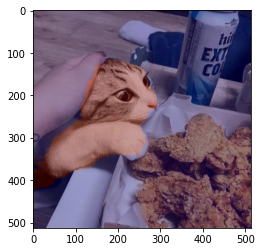

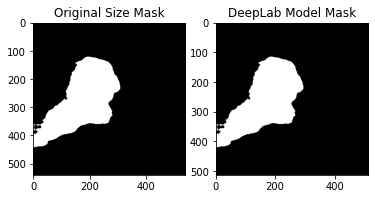

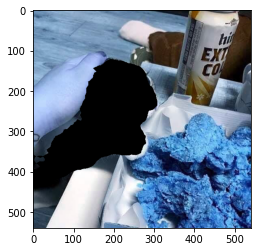

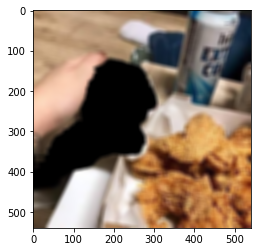

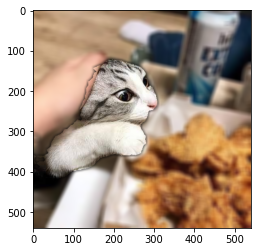

In [61]:
blur_background('2.jpg', 'cat')

![인물](https://github.com/fmfmsd/Chamchee/blob/main/Exploration/Ex9/img/%EC%9D%B8%EB%AC%BC.png?raw=truee)
![인물1](https://github.com/fmfmsd/Chamchee/blob/main/Exploration/Ex9/img/%EC%9D%B8%EB%AC%BC1.png?raw=true)

# 배경합성

In [74]:
def chroma_key(file, label, background):
    # 이미지 불러오기
    img_path = os.path.join(img_dir_path, file)
    img_orig = cv2.imread(img_path)
        
    # 이미지를 pre-trained 모델에 입력
    img_resized, seg_map = MODEL.run(img_orig)

    # 배경과 피사체 분리하기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) # 예측 중 특정 라벨만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    # 배경 이미지 불러오기
    bg_path = os.path.join(img_dir_path, background)
    bg_orig = cv2.imread(bg_path)
    target_size = (img_orig.shape[1], img_orig.shape[0])
    bg_resized = cv2.resize(bg_orig, target_size)
        
    # 배경과 원본 이미지 합성 후 저장
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_concat = np.where(img_mask_color==255, img_orig, bg_resized)
    save_path = os.path.join(save_dir_path, file)
    cv2.imwrite(save_path, img_concat)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

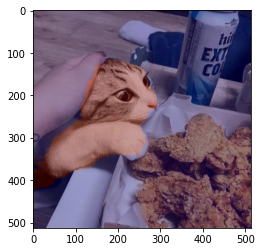

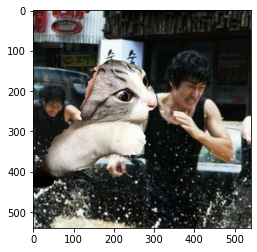

In [82]:
chroma_key('2.jpg', 'cat', 'rub.jpg')

In [ ]:
chroma_key('2.jpg', 'cat', 'rub.jpg')

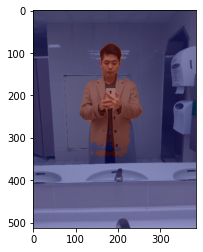

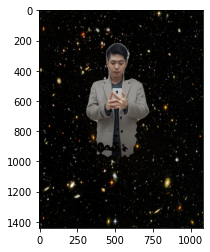

In [92]:
chroma_key('one1.jpg', 'person', '123.jpg')

# 문제정의

![고양이](https://github.com/fmfmsd/Chamchee/blob/main/Exploration/Ex9/img/%EA%B3%A0%EC%96%91%EC%9D%B4.png?raw=truee)
![고양이1](https://github.com/fmfmsd/Chamchee/blob/main/Exploration/Ex9/img/%EA%B3%A0%EC%96%91%EC%9D%B41.png?raw=true)
![인물](https://github.com/fmfmsd/Chamchee/blob/main/Exploration/Ex9/img/%EC%9D%B8%EB%AC%BC.png?raw=true)
![인물1](https://github.com/fmfmsd/Chamchee/blob/main/Exploration/Ex9/img/%EC%9D%B8%EB%AC%BC1.png?raw=true)


- 의외로 분류는 잘하지만 세밀함이 많이 떨어졌다. 아무래도 sagmentation의 한계가 드러난 것 같다.

- 스마트폰 카메라의 경우, 여러렌즈와 센서를 사용하여 피사계 심도를 쉽게 조정하여 아웃포커싱을 깔끔하게 할 수 있다. segmentation의 경우 학습된 라벨안에서만 분류를 하는 것이기 때문에 조금이라도 범위 안에서 벗어나게 되면 인식을 못하는 것 같다.(위 그림의 빨간 원에 나타나는 현상)

- 범위를 벗어난 다는 것은 loss값이 커져서 인식을 못 한다는 뜻이다.하지만 이런 현상을 해결하기 위한 방법이 있다. 2021년 11월 8일에 발표된 SimMIM이다. (https://arxiv.org/abs/2111.09886)

- SimMIM을 사용하면 시각화 실험에서 사전 훈련된 이미지 모델의 예제 프레임워크 를 보다 간단하고 효과적으로 처리할 수 있습니다. 다음과 같이 네가지의 주요 구성으로 동작을 하게 된다.

1. 토큰화 마스킹을 이용하여 적당한 마스크처리 
2. 마스킹된 토큰과 이미지 토큰은 인코더에서 함께 처리. 
3. 선형 레이어로 예측 간단하게.
4. RGB 값의 원시 픽셀을 `1 손실로 대상으로 직접 예측 직접 회귀.

- 시간이 부족해서 논문을 정확히 읽어 보지는 못하였으나 일단 pdf 파일을 git에 업로드 하여서 시간이 될 때 확인 해봐야 겠다.